In [1]:
import pandas as pd
import numpy as np
import urllib
import glob
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler


import geopandas as gpd
import shapely
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from geopandas.tools import sjoin
from fiona.crs import from_epsg
import libpysal as lps
from libpysal.weights import Kernel
import mapclassify as mc

import math
from math import sin, cos, sqrt, atan2

plt.style.use('ggplot')


% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
url = 'https://raw.githubusercontent.com/lavsz/dsc-mod-2-project-v2-1-onl01-dtsc-pt-052620/master/kc_house_data.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# <span style="color:##FF1493"> 1. Clean and formatting </span>
Waterfront, Basement, Renovating year Values, Date

## 1.1 Waterfront

In [6]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [7]:
# Water front
# Based on King's County's map
# we assume that if any houses with nan value fall within the follow zips
# Are going to assign a 1, otherwise 0 
water_zip = [98177, 98117, 98199, 98119, 98121, 
             98101, 98104, 98134, 98126, 98116, 
             98136, 98136, 98166, 98196, 98070]
df['waterfront_adj'] = df['waterfront']
for i in range(len(df)):
    if np.isnan(df['waterfront_adj'][i]) == 1:
        if df.zipcode[i] in water_zip:
            df['waterfront_adj'][i] = 1
        elif df.zipcode[i] not in water_zip:
            df['waterfront_adj'][i] = 0
        else:
            df['waterfront_adj'][i] = df.waterfront[i]

## 1.2 Basement Square Footage

In [8]:
# Basement sqft is object is very odd
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [9]:
# replace the '?' with 0.0 first
# change the dtype to float
df.sqft_basement = df.sqft_basement.str.replace('?', '0.0')
df.sqft_basement = df.sqft_basement.astype(float)

## 1.3 Renovating years

In [10]:
# renovating years
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [11]:
# replace nan with just 0 
df.yr_renovated = df.yr_renovated.fillna(0)
df.yr_renovated.unique()

array([   0., 1991., 2002., 2010., 1992., 2013., 1994., 1978., 2005.,
       2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990., 1988.,
       1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955., 1982.,
       1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1967., 1965., 1934., 1972., 1944., 1958.])

## 1.4 Sales date

In [12]:
# Sales data to datetime format
# Easy to extract month, year, weekdays for further analysis
df.date = pd.to_datetime(df.date, format='%m/%d/%Y')

## 1.5 Views

In [13]:
df.view = df.view.fillna(0)

## <span style="color:##FF1493"> 1.6 Finding outliers </span>

In [14]:
with pd.option_context('display.max_columns', 40):
    print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233181      3.409825   
std    4.141264e+04      0.539683      0.086825    

In [15]:
# 33 bedrooms seems very odd and need to check out the size of the house
bed_33 = df[df.bedrooms == 33]
bed_33

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_adj
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,0.0


In [16]:
# Based on the number of bathrooms, living sqft, it is definitely a typo
# The value will be corrected to 3 instead
df.bedrooms = df.bedrooms.replace({33: 3})

In [17]:
# Creating new features
df['FAR'] = (df.sqft_living/df.floors)/df.sqft_lot
df['bd_ba_ratio'] = df.bedrooms/df.bathrooms
df['age'] = df.date.dt.year - df.yr_built
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront_adj', 'FAR',
       'bd_ba_ratio', 'age'],
      dtype='object')

## 1.7 Colinearity and First correlation check

In [18]:
df.corr()['price'].sort_values()

bd_ba_ratio      -0.254212
age              -0.053890
zipcode          -0.053402
id               -0.016772
long              0.022036
condition         0.036056
yr_built          0.053953
FAR               0.061134
sqft_lot15        0.082845
sqft_lot          0.089876
yr_renovated      0.117855
waterfront_adj    0.166670
floors            0.256804
waterfront        0.276295
lat               0.306692
bedrooms          0.315954
sqft_basement     0.321108
view              0.393497
bathrooms         0.525906
sqft_living15     0.585241
sqft_above        0.605368
grade             0.667951
sqft_living       0.701917
price             1.000000
Name: price, dtype: float64

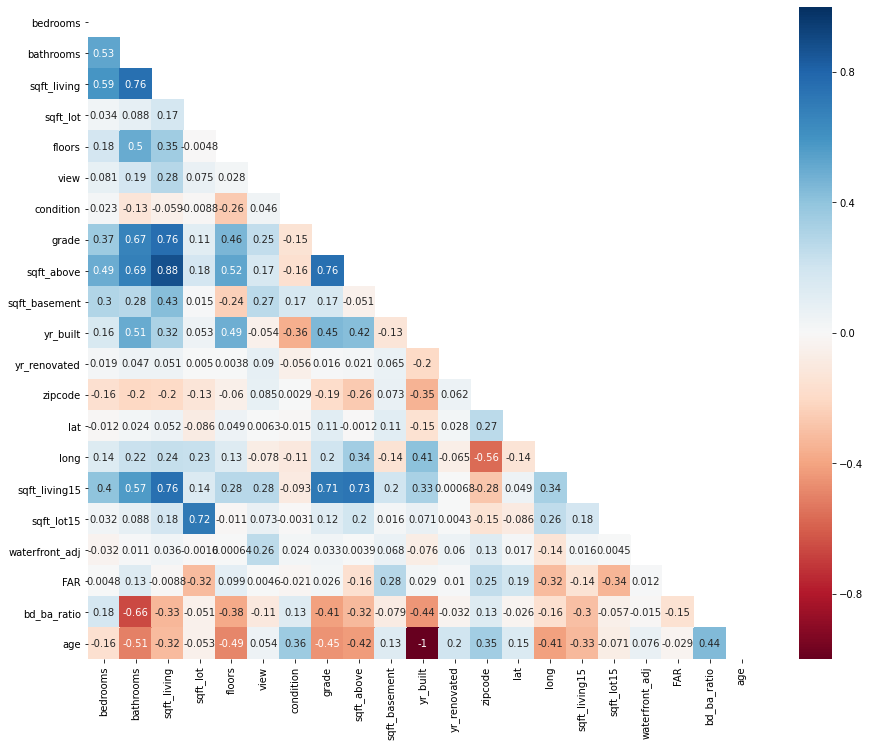

In [19]:
plt.figure(figsize=(15,12))
df_var = df.drop(['price', 'id', 'waterfront'], axis=1)
corr = df_var.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu', annot = True)
# 0.7 is a threshold; 

## Interpretations: 
**sqft_living15 & sqft_above** - seems to have strong correlation with many features
<br/>
**sqft_lot15** - not likely going to use it
<br/>
**yr_built** - derived age; and will be dropped
<br/>
**yr_renoved** - many 0 values; it could be that most houses were not renoted or can also be value was acquired; will be dropped
<br/>
**bathroom & bedroom ** - have strong correlation with some features - can be turn into a categorical feature
<br/>
**bd_ba_ratio** - is probably not a good representation as 6 vs 4 and 3 vs 2 have the same ratio but different numbers

# 2. Q1: Price prediction from House Features

## 2.1 Creating Relevant Subsets and Initial Inspection
Subsets Based on Price Tiers (Bottom, Middle, Top)
Preliminary analysis on house features

In [20]:
# Creating three subsets based on the price
df_x = df[(df.price >= 78000) & (df.price <= 300000)]
df_y = df[(df.price >= 300001) & (df.price <= 800000)]
df_z = df[(df.price >= 800001) & (df.price <= 7700000)]

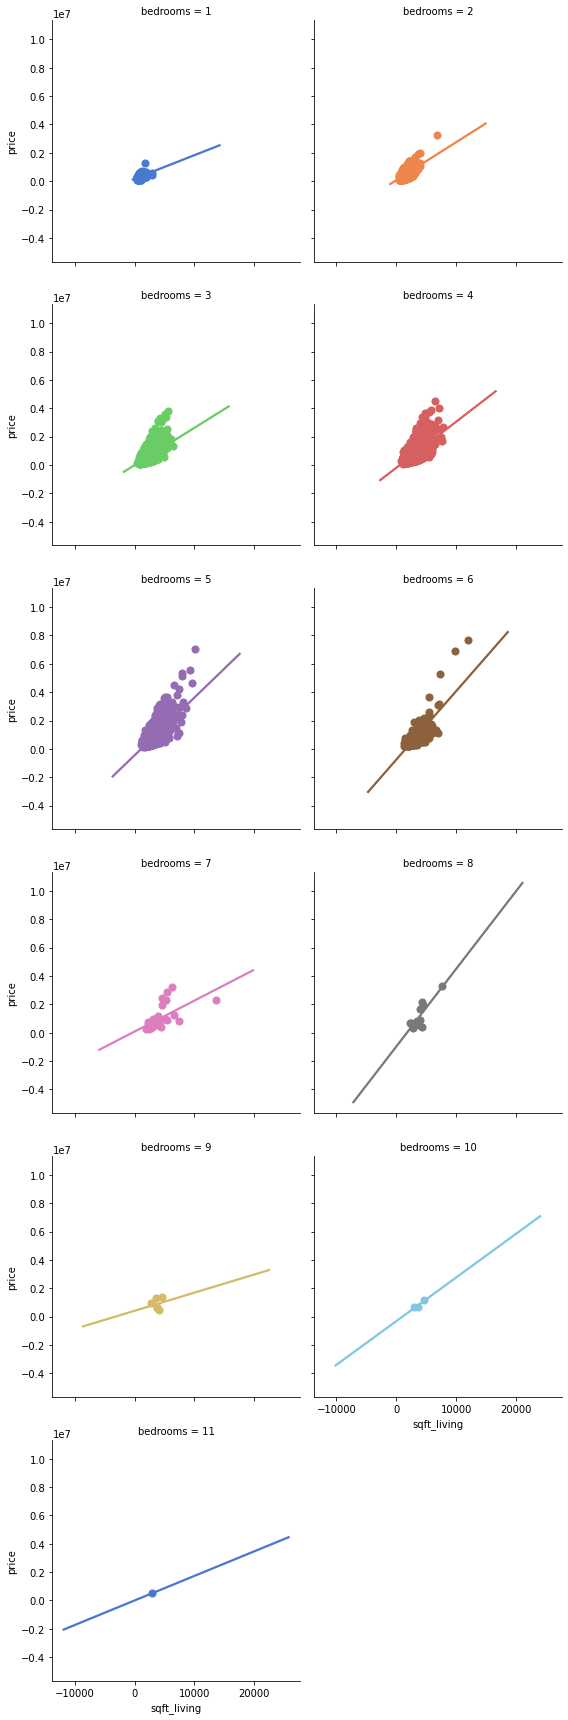

In [21]:
#1 of 2, Analyzing Square Foot Living and Bedrooms
a1 = sns.lmplot(x="sqft_living", y="price", col="bedrooms", hue="bedrooms", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

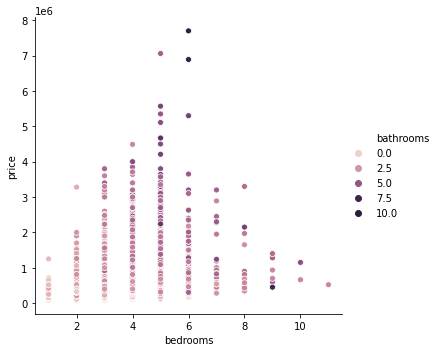

In [22]:
#Another Preliminary Analysis
#2 of 2, Checking Bedrooms and Bathrooms
sns.relplot(x="bedrooms", y="price", hue="bathrooms", data=df)

## 2.2 OLS Analysis for Master DF and Subsets

In [23]:
#Creating a function to repeat across DFs
def make_ols(df, columns_to_use, columns_to_drop=None, target='price', add_constant=False):
    if columns_to_drop:
        columns_to_drop.append(target)
        X = df.drop(columns=columns_to_drop)
    else:
        X = df[columns_to_use]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    return res


def make_sklearn_ols():
    return 

### First model with selected features
Based on VIF scores, the below features (Floors and Condition) have the lowest multicollinearity. 

In [24]:
bottom_tier = make_ols(df_x, columns_to_use=[ 'bedrooms', 'floors', 'condition', 'sqft_living'])
#sqft_lot dropped due to a violation of CLR assumptions, despite its low multicollinearity (non-constant variance).

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          3.253e+04
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:00:12   Log-Likelihood:                         -55340.
No. Observations:                4561   AIC:                                  1.107e+05
Df Residuals:                    4557   BIC:                                  1.107e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms     6106.7547   1063.538      5.742      0.000    4021.705    8191.805
floors       3.893e+04   1515.716     25.684      0.000     3.6e+04    4.19e+04
condition     3.03e+04    658.353     46.025      0.000     2.9e+04    3.16e+04
sqft_living    47.2203      1.985     23.786      0.000      43.328      51.112
==============================================================================
Omnibus:                        0.980   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.994
Skew:                          -0.036   Prob(JB):                        0.608
Kurtosis:                       2.986   Cond. No.                     3.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation: 
The R score is very high and all three variables have very low P-values

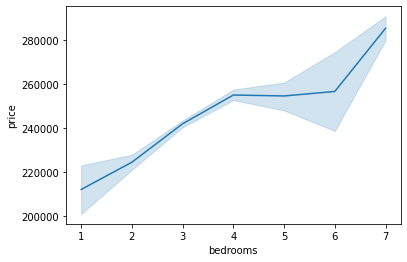

In [25]:
# Bottom tier bedroom vs price graph
ax = sns.lineplot(x="bedrooms", y="price", data=df_x)

In [26]:
mid_tier = make_ols(df_y, columns_to_use=['bedrooms', 'floors', 'bathrooms', 'condition', 'sqft_living'])
#sqft_lot dropped due to a violation of CLR assumptions, despite its low multicollinearity (non-constant variance).

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                          4.526e+04
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:00:13   Log-Likelihood:                     -1.8535e+05
No. Observations:               14093   AIC:                                  3.707e+05
Df Residuals:                   14088   BIC:                                  3.708e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms    -2933.2809   1449.660     -2.023      0.043   -5774.807     -91.755
floors       4.707e+04   2025.830     23.233      0.000    4.31e+04     5.1e+04
bathrooms    2104.8822   2342.838      0.898      0.369   -2487.390    6697.154
condition    6.911e+04   1026.585     67.322      0.000    6.71e+04    7.11e+04
sqft_living    95.1394      2.214     42.965      0.000      90.799      99.480
==============================================================================
Omnibus:                      182.507   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.018
Skew:                           0.181   Prob(JB):                     4.38e-33
Kurtosis:                       2.650   Cond. No.                     5.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation:
The R square is pretty high. Bathroom number has a high P value and we cannot reject the null hypothesis of Bathroom number has no impact on price. Bedroom number also has a sitting-on-edge P value so the significance of this feature is low.

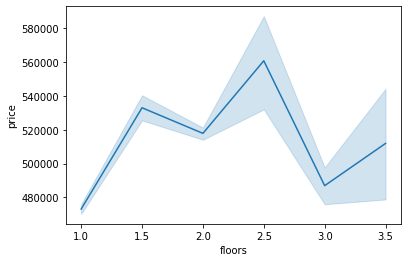

In [27]:
ax = sns.lineplot(x="floors", y="price", data=df_y)

In [28]:
top_tier = make_ols(df_z, columns_to_use=['bedrooms', 'floors', 'sqft_lot', 'bathrooms', 'condition', 'sqft_living'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                              4054.
Date:                Wed, 09 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:00:14   Log-Likelihood:                         -42397.
No. Observations:                2943   AIC:                                  8.481e+04
Df Residuals:                    2937   BIC:                                  8.484e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms    -6.956e+04   9738.297     -7.143      0.000   -8.87e+04   -5.05e+04
floors      -5.231e+04    1.6e+04     -3.278      0.001   -8.36e+04    -2.1e+04
sqft_lot       -0.9463      0.138     -6.852      0.000      -1.217      -0.675
bathrooms    7.385e+04   1.46e+04      5.054      0.000    4.52e+04    1.03e+05
condition    1.021e+05   8097.901     12.613      0.000    8.63e+04    1.18e+05
sqft_living   305.0833     11.123     27.428      0.000     283.274     326.893
==============================================================================
Omnibus:                     1309.376   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11213.386
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      11.775   Cond. No.                     1.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Partial Regression Plot for Bottom_tier-Priced Houses


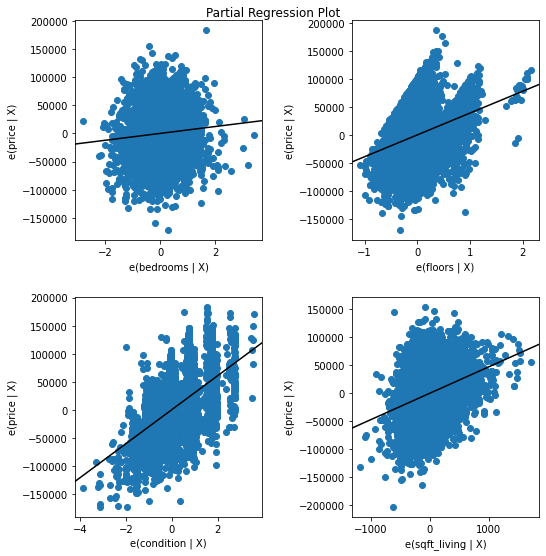

In [29]:
fig = plt.figure(figsize=(8, 8))
fig1 = sm.graphics.plot_partregress_grid(bottom_tier, fig=fig)
fig1.tight_layout(pad=2.2)
print('Partial Regression Plot for Bottom_tier-Priced Houses')

Partial Regression Plot for Mid_tier-Priced Houses


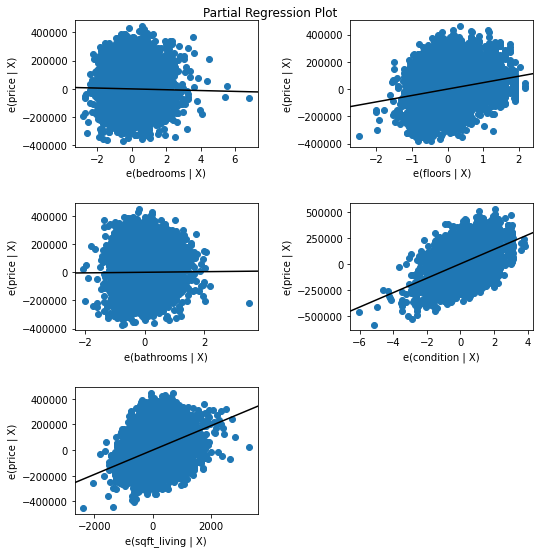

In [30]:
fig = plt.figure(figsize=(8, 8))
fig2 = sm.graphics.plot_partregress_grid(mid_tier, fig=fig)
fig2.tight_layout(pad=2.5)
print('Partial Regression Plot for Mid_tier-Priced Houses')

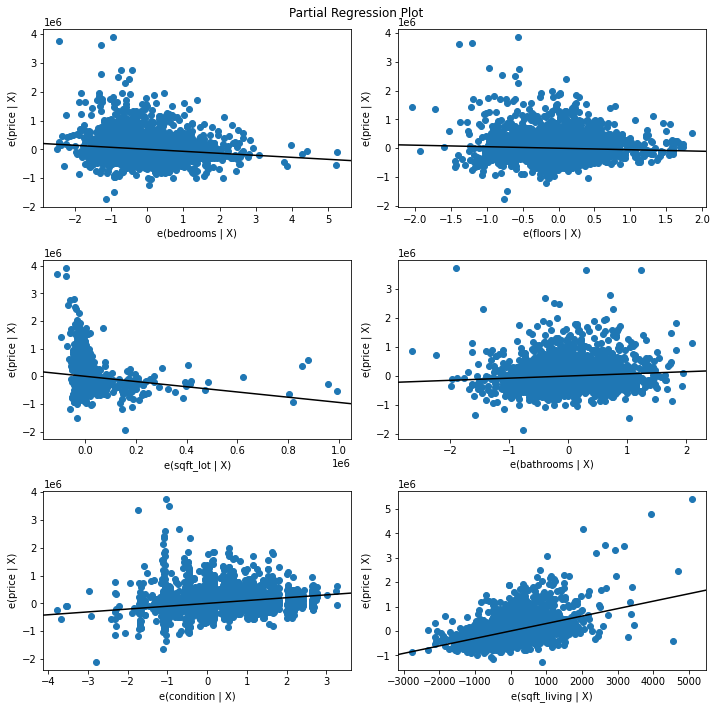

In [31]:
fig = plt.figure(figsize=(10, 10))
fig3 = sm.graphics.plot_partregress_grid(top_tier, fig=fig)
fig2.tight_layout(pad=3.5)

## 2.3 Multicollinearity Analysis and MSE Features

In [32]:
# Model results for Master DF
# based on the above, floors and sqft_living are chosen as important housing features
columns = df.drop(columns=['id', 'date', 'view', 'waterfront', 'zipcode', 'lat', 'long', 'sqft_living15',
                           'sqft_lot15', 'yr_renovated', 'yr_built', 'sqft_basement', 
                          'sqft_above', 'grade', 'condition']).columns
columns = ['floors', 'sqft_living']
vif_scores = []
for column in columns:
    target_column = column
    columns_to_use = [c for c in columns if c!=target_column]
    X = df[columns_to_use]
    y = df[target_column]

    ols = sm.OLS(y, X)
    res = ols.fit()
    r2 = res.rsquared
    vif = 1 / (1 - r2) 
    vif_scores.append((column, vif))
vif_scores

[('floors', 5.756916163755017), ('sqft_living', 5.756916163755021)]

In [33]:
# Bottom Tier Subset
# Floors and house conditions are chosen
columns = df_x.drop(columns=['id', 'date', 'view', 'waterfront', 'zipcode', 'lat', 'long', 'sqft_living15',
                           'sqft_lot15', 'yr_renovated', 'yr_built', 'sqft_basement', 
                          'sqft_above', 'grade', 'condition']).columns
columns = ['floors', 'condition']
vif_scores = []
for column in columns:
    target_column = column
    columns_to_use = [c for c in columns if c!=target_column]
    X = df_x[columns_to_use]
    y = df_x[target_column]

    ols = sm.OLS(y, X)
    res = ols.fit()
    r2 = res.rsquared
    vif = 1 / (1 - r2) 
    vif_scores.append((column, vif))
vif_scores

[('floors', 6.3485151626534195), ('condition', 6.348515162653411)]

In [34]:
# Middle Tier Subset
# Floor, sqft_living, and condition are chosen
columns = df_y.drop(columns=['id', 'date', 'view', 'waterfront', 'zipcode', 'lat', 'long', 'sqft_living15',
                           'sqft_lot15', 'yr_renovated', 'yr_built', 'sqft_basement', 
                          'sqft_above', 'grade']).columns
columns = ['floors', 'sqft_living', 'condition' ]
vif_scores = []
for column in columns:
    target_column = column
    columns_to_use = [c for c in columns if c!=target_column]
    X = df_y[columns_to_use]
    y = df_y[target_column]

    ols = sm.OLS(y, X)
    res = ols.fit()
    r2 = res.rsquared
    vif = 1 / (1 - r2) 
    vif_scores.append((column, vif))
vif_scores

[('floors', 7.259177142299182),
 ('sqft_living', 9.110978874021503),
 ('condition', 8.011681881288505)]

In [35]:
#Top Tier Subset
columns = df_z.drop(columns=['id', 'date', 'view', 'waterfront', 'zipcode', 'lat', 'long', 'sqft_living15',
                           'sqft_lot15', 'yr_renovated', 'yr_built', 'sqft_basement', 
                          'sqft_above', 'grade']).columns
columns = ['sqft_living', 'condition']
vif_scores = []
for column in columns:
    target_column = column
    columns_to_use = [c for c in columns if c!=target_column]
    X = df_z[columns_to_use]
    y = df_z[target_column]

    ols = sm.OLS(y, X)
    res = ols.fit()
    r2 = res.rsquared
    vif = 1 / (1 - r2) 
    vif_scores.append((column, vif))
vif_scores

[('sqft_living', 6.72726083559541), ('condition', 6.7272608355954056)]

### Test/Train Split and MSE

In [130]:
# Split the dataset into training and testing sets
for column in columns:
    target_column = column
    columns_to_use = [c for c in columns if c!=target_column]
    X = df[columns_to_use]
    y = df[target_column]
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
# Building linear model, fit the training set and predicting the testing set
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [132]:
# Calculating residuals for two sets
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [133]:
# Calculating MSE
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.42216649912589294
Test Mean Squarred Error: 0.419824782768797


In [134]:
y_pred = linreg.predict(X_test)
print(metrics.mean_squared_error(y_test, y_pred))

0.419824782768797


### Analysis on Residuels
Using QQ Plots and regression plots

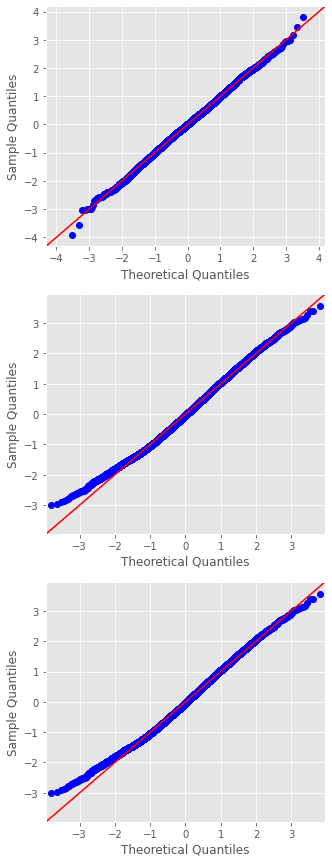

In [135]:
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=(5,15))
residuals = bottom_tier.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=ax1)


residuals1 = mid_tier.resid
fig = sm.graphics.qqplot(residuals1, dist=stats.norm, line='45', fit=True, ax=ax2)

residuals2 = top_tier.resid
fig = sm.graphics.qqplot(residuals1, dist=stats.norm, line='45', fit=True, ax=ax3)

## Interpretation: 
From the QQ plots, we can see that the train-test split was good since the testing and training sets shows similar distribution

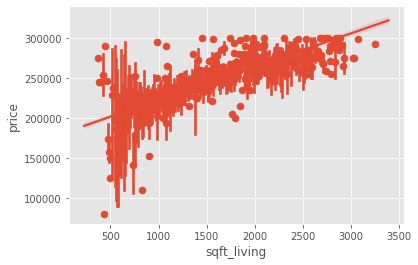

In [136]:
sns.regplot(x="sqft_living", y="price", data=df_x,
                 x_estimator=np.mean)


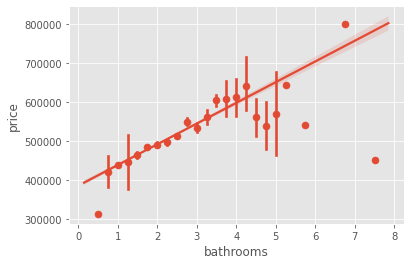

In [137]:
ax2 = sns.regplot(x="bathrooms", y="price", data=df_y,
                 x_estimator=np.mean)

# 2.4 Conclusions
After dividing the King County dataset into subsets based on price, a few key observations emerged. While some trends (lot square footage) stayed constant, others peaked and ebbed depending on the sale price. 

Note: pricing tiers were set due from Zillow, Redfin's and Realtor.com's listing data. 

1. For the "bottom_tier," or homes priced 78,000 to 300,000, floors, condition, bedrooms and square footage had the strongest affect on price. 
2. For the "mid_tier," or homes priced 300,0000 to 800,000, the size of the home mattered most: bathrooms, bedrooms, floors, and square footage had the highest impact on price. 
3. The "top_tier," or homes priced 800,000 to 7,700,000, shared little characteristics with the previous two tiers, condition and square footage weighing out any other features. 

# 3. Q2: Marketing and time-series (multivariate, conditional linear reg) can include but not limited to:
Seasonal trend of sales amount, price, house features
<br/>
Seasonal trend of neighbourhood features (perhaps people like to look at waterfront houses in Summer)
<br/>
Categorize features from neighbourhood and generalize overall price for neighbourhoods (spatial lag correction can imply)
<br/>

## 3.1 Feature engineering to reduce impact of Colinearity

In [44]:
df['bed_bath'] = (df['bedrooms'].astype(int)*100).astype(str) + '_' + ((df['bathrooms']*100).astype(int)).astype(str)

In [45]:
df_clean = df.drop(['waterfront', 'sqft_living15', 'sqft_above', 'sqft_lot15',
                    'yr_built', 'yr_renovated', 'bathrooms', 'bedrooms'], axis=1)

In [46]:
# Creating a new columns - floor area ratio
df_clean['FAR'] = df_clean.sqft_living/df_clean.sqft_lot

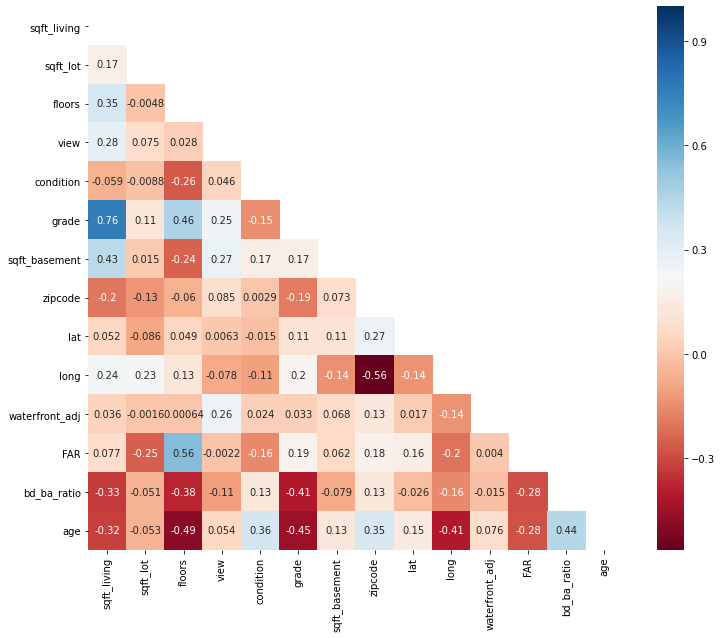

In [47]:
plt.figure(figsize=(12,10))
df_clean_v = df_clean.drop(['price', 'id'], axis=1)
corr_v = df_clean_v.corr()
mask = np.triu(np.ones_like(corr_v, dtype=np.bool))
sns.heatmap(corr_v, mask=mask,
        xticklabels=corr_v.columns,
        yticklabels=corr_v.columns, cmap='RdBu', annot = True)

## Interpretation: 
**Age** might be not easy to interpret when it comes to dealing with price but condition can possibly speak more.
<br/>
**Grade** has a very correlation with sqft_living; it will be turned to categorical data

In [48]:
# getting month & seanson features from data
df_clean['month'] = df_clean.date.dt.month
df_clean['season'] = ' '
df_clean.loc[df_clean.month.isin([3,4,5]), 'season'] = 'Spring'
df_clean.loc[df_clean.month.isin([6,7,8]), 'season'] = 'Summer'
df_clean.loc[df_clean.month.isin([9,10,11]), 'season'] = 'Fall'
df_clean.loc[df_clean.month.isin([12,1,2]), 'season'] = 'Winter'

In [49]:
# change a few features to integer to avoid naming issues
df_clean.view = df_clean.view.astype(int)
df_clean.waterfront_adj = df_clean.waterfront_adj.astype(int)
df_clean.condition = df_clean.condition.astype(int)

In [50]:
# Seasonal a new dataframe for the seasonal analysis
df_marking = df_clean[['id', 'date', 'price', 'sqft_living',
       'sqft_lot', 'view', 'condition', 'grade',
       'lat', 'long', 'waterfront_adj',
       'season', 'FAR', 'bed_bath']]

In [51]:
# Demographic and District for map visualization
demographic = 'https://opendata.arcgis.com/datasets/e23a07e847a7440dabac76ede52b521d_2687.zip'
urllib.request.urlretrieve(demographic, 'demo_file.gz')
!mkdir demographic
!unzip -d demographic demo_file.gz
demos = gpd.GeoDataFrame.from_file(glob.glob("demographic/*.shp")[0])

mkdir: demographic: File exists
Archive:  demo_file.gz
replace demographic/Consolidated_Demographics_Index_for_King_County_Census_Tracts___demographic_index_area.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [52]:
# Turning into categorical data
df_marking.grade = df_marking.grade.astype('category')
df_marking['bed_bath'] = df_marking['bed_bath'].astype('category')
df_marking.waterfront_adj = df_marking.waterfront_adj.astype('category')
df_marking.view = df_marking.view.astype('category')
df_marking.condition = df_marking.condition.astype('category')

# Making dummies
grade = pd.get_dummies(df_marking.grade, prefix='grade')   
bed_bath = pd.get_dummies(df_marking['bed_bath'], prefix='bb_ratio')
wat = pd.get_dummies(df_marking.waterfront_adj, prefix='waterfront')
view = pd.get_dummies(df_marking.view, prefix='view')
condition = pd.get_dummies(df_marking.condition, prefix='condition')

In [53]:
df_marking_a = df_marking.join([grade, condition, wat, view, bed_bath])
df_marking_analysis = df_marking_a.drop(['grade', 'view', 'bed_bath',
                                         'waterfront_adj', 'condition'], axis=1)
df_marking_analysis.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'lat', 'long',
       'season', 'FAR', 'grade_3',
       ...
       'bb_ratio_800_325', 'bb_ratio_800_350', 'bb_ratio_800_375',
       'bb_ratio_800_400', 'bb_ratio_800_500', 'bb_ratio_800_600',
       'bb_ratio_900_300', 'bb_ratio_900_400', 'bb_ratio_900_450',
       'bb_ratio_900_750'],
      dtype='object', length=169)

## 3.2 Quick seasonal visualization

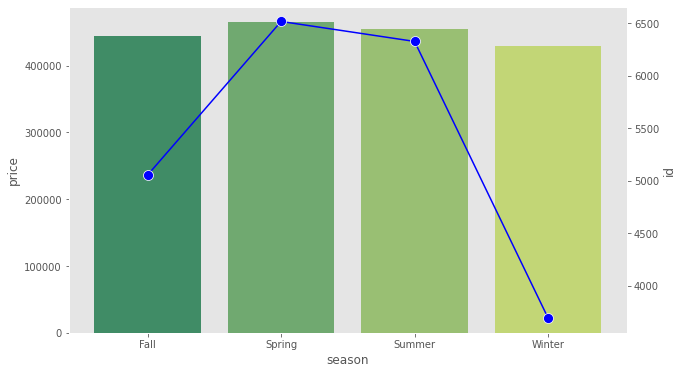

In [54]:
# Visualizing basic info of each season


fig, ax1 = plt.subplots(figsize=(10,6))
ax1 = sns.barplot(x = df_marking['price'].groupby(df_marking.season).median().index, 
                  y = df_marking['price'].groupby(df_marking.season).median(), palette='summer')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x = df_marking['id'].groupby(df_marking.season).count().index, 
                   y = df_marking['id'].groupby(df_marking.season).count(),
                color='blue', marker='o', markersize=10)
ax2.grid(False)
ax1.grid(False)

In [55]:
# Slicing the data into four subsets representing each season
df_fall = df_marking_analysis[df_marking_analysis.season == 'Fall']
df_winter = df_marking_analysis[df_marking_analysis.season == 'Winter']
df_spring = df_marking_analysis[df_marking_analysis.season == 'Spring']
df_summer = df_marking_analysis[df_marking_analysis.season == 'Summer']

# Creating geo dataframe for each season
geo_fall = gpd.GeoDataFrame(df_fall, geometry=gpd.points_from_xy(df_fall.long, df_fall.lat))
geo_winter = gpd.GeoDataFrame(df_winter, geometry=gpd.points_from_xy(df_winter.long,
                                    df_winter.lat))
geo_spring = gpd.GeoDataFrame(df_spring, geometry=gpd.points_from_xy(df_spring.long,
                                    df_spring.lat))
geo_summer = gpd.GeoDataFrame(df_summer, geometry=gpd.points_from_xy(df_summer.long,
                                    df_summer.lat))

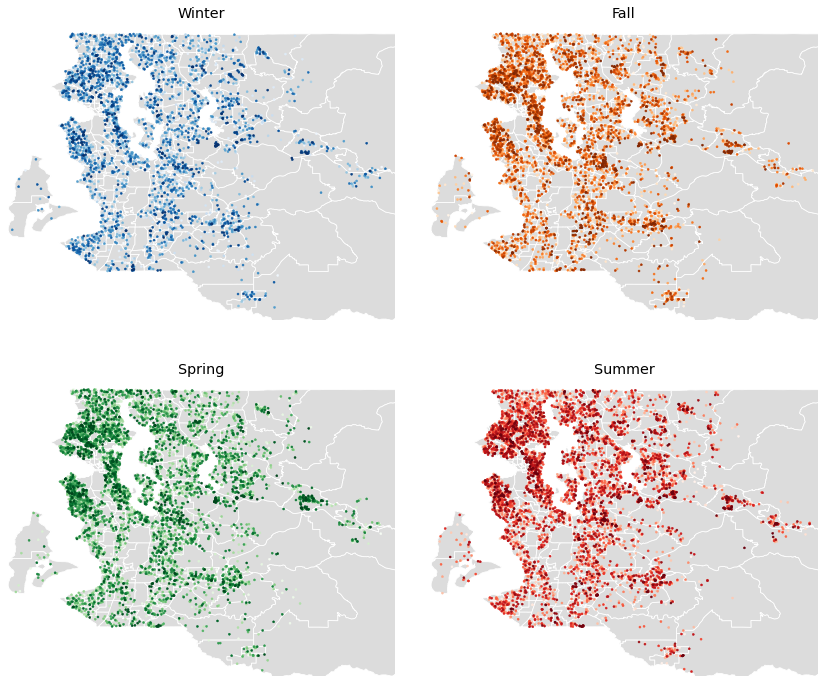

In [56]:
# Geospatil distribution
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
set1 = demos.plot(color='#DCDCDC', ax=ax1, edgecolor='white', linewidth=0.8, legend=True)
set2 = geo_winter.plot(c=geo_winter.price, cmap='Blues', ax=ax1, markersize=4)
set1.set_xlim(-122.53, -121.68)
set1.set_ylim(47.15, 47.8)
set1.axis('off')
set1.set_title('Winter')

ax2 = fig.add_subplot(222)
set3 = demos.plot(color='#DCDCDC', ax=ax2, edgecolor='white', linewidth=0.8,  legend=True)
set4 = geo_fall.plot(c=geo_fall.price, cmap='Oranges',ax=ax2, markersize=4)
set3.set_xlim(-122.53, -121.68)
set3.set_ylim(47.15, 47.8)
set3.axis('off')
set3.set_title('Fall')

ax3 = fig.add_subplot(223)
set5 = demos.plot(color='#DCDCDC', ax=ax3, edgecolor='white',linewidth=0.8,  legend=True)
set6 = geo_spring.plot(c=geo_spring.price, cmap='Greens', ax=ax3, markersize=4)
set5.set_xlim(-122.53, -121.68)
set5.set_ylim(47.15, 47.8)
set5.axis('off')
set5.set_title('Spring')

ax4 = fig.add_subplot(224)
set7 = demos.plot(color='#DCDCDC', ax=ax4, edgecolor='white', linewidth=0.8, legend=True)
set8 = geo_summer.plot(c=geo_summer.price, cmap='Reds', ax=ax4, markersize=4)
set7.set_xlim(-122.53, -121.68)
set8.set_ylim(47.15, 47.8)
set7.axis('off')
set7.set_title('Summer')
plt.subplots_adjust(wspace= -0.1)

## 3.3 OLS Model and Feature selection

In [57]:
# Overall model base
target = 'price'
predictors = df_marking_analysis.drop(['id', 'price', 'date', 'lat', 'long'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_all = smf.ols(formula=formula, data=df_marking_analysis).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     279.9
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:02:58   Log-Likelihood:            -2.9517e+05
No. Observations:               21597   AIC:                         5.907e+05
Df Residuals:                   21435   BIC:                         5.919e+05
Df Model:                         161                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.906e+05   1.42e+04     27.541      0.000    3.63e+05    4.18e+05
season[T.Spring]   2.828e+04   3937.781      7.181      0.000    2.06e+04     3.6e+04
season[T.Summer]   4906.3969   3967.445      1.237      0.216   -2870.091    1.27e+04
season[T.Winter]  -3818.4715   4549.919     -0.839      0.401   -1.27e+04    5099.710
sqft_living         153.5862      3.421     44.893      0.000     146.881     160.292
sqft_lot             -0.1701      0.037     -4.595      0.000      -0.243      -0.098
FAR                1.137e+05   6405.955     17.743      0.000    1.01e+05    1.26e+05
grade_3           -3.497e+05   1.95e+05     -1.792      0.073   -7.32e+05    3.29e+04
grade_4           -3.565e+05   4.35e+04     -8.201      0.000   -4.42e+05   -2.71e+05
grade_5           -3.657e+05    2.4e+04    -15.247      0.000   -4.13e+05   -3.19e+05
grade_6           -3.285e+05   2.11e+04    -15.568      0.000    -3.7e+05   -2.87e+05
grade_7           -2.629e+05   2.07e+04    -12.710      0.000   -3.03e+05   -2.22e+05
grade_8           -1.844e+05   2.07e+04     -8.911      0.000   -2.25e+05   -1.44e+05
grade_9           -5.332e+04   2.09e+04     -2.555      0.011   -9.42e+04   -1.24e+04
grade_10           1.085e+05   2.14e+04      5.081      0.000    6.67e+04     1.5e+05
grade_11           3.218e+05   2.31e+04     13.937      0.000    2.77e+05    3.67e+05
grade_12           6.927e+05   3.06e+04     22.650      0.000    6.33e+05    7.53e+05
grade_13           1.169e+06   6.88e+04     16.987      0.000    1.03e+06     1.3e+06
condition_1        5.359e+04   3.24e+04      1.655      0.098   -9870.826    1.17e+05
condition_2        4.451e+04   1.52e+04      2.919      0.004    1.46e+04    7.44e+04
condition_3        3.626e+04   8407.944      4.313      0.000    1.98e+04    5.27e+04
condition_4        9.022e+04   8534.090     10.571      0.000    7.35e+04    1.07e+05
condition_5         1.66e+05   9189.228     18.065      0.000    1.48e+05    1.84e+05
waterfront_0        1.09e+05   8279.063     13.160      0.000    9.27e+04    1.25e+05
waterfront_1       2.816e+05   9612.105     29.299      0.000    2.63e+05       3e+05
view_0            -8.459e+04   5088.138    -16.624      0.000   -9.46e+04   -7.46e+04
view_1             5.966e+04   1.05e+04      5.708      0.000    3.92e+04    8.01e+04
view_2             4902.5504   7245.099      0.677      0.499   -9298.385    1.91e+04
view_3             6.278e+04   8912.411      7.044      0.000    4.53e+04    8.03e+04
view_4             3.478e+05    1.1e+04     31.479      0.000    3.26e+05    3.69e+05
bb_ratio_1000_200 -1.791e+05   2.08e+05     -0.860      0.390   -5.87e+05    2.29e+05
bb_ratio_1000_300 -1.149e+05   2.08e+05     -0.552      0.581   -5.23e+05    2.93e+05
bb_ratio_1000_525 -9.317e+04   2.08e+05     -0.447      0.655   -5.01e+05

In [58]:
# Fall model
target = 'price'
predictors = df_fall.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_fall = smf.ols(formula=formula, data=df_fall).fit()
model_fall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     127.2
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:03:01   Log-Likelihood:                -68583.
No. Observations:                5056   AIC:                         1.374e+05
Df Residuals:                    4937   BIC:                         1.382e+05
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.402e+05   1.78e+04     24.787      0.000    4.05e+05    4.75e+05
sqft_living         142.1755      6.491     21.902      0.000     129.449     154.902
sqft_lot             -0.1194      0.072     -1.659      0.097      -0.261       0.022
FAR                 1.17e+05   1.21e+04      9.660      0.000    9.32e+04    1.41e+05
grade_3            9.452e-07   2.83e-07      3.335      0.001     3.9e-07     1.5e-06
grade_4           -3.514e+05   7.23e+04     -4.857      0.000   -4.93e+05    -2.1e+05
grade_5           -3.969e+05   2.74e+04    -14.493      0.000   -4.51e+05   -3.43e+05
grade_6           -3.586e+05   1.89e+04    -18.929      0.000   -3.96e+05   -3.21e+05
grade_7           -2.784e+05   1.69e+04    -16.510      0.000   -3.12e+05   -2.45e+05
grade_8           -1.933e+05   1.68e+04    -11.502      0.000   -2.26e+05    -1.6e+05
grade_9           -7.726e+04   1.73e+04     -4.457      0.000   -1.11e+05   -4.33e+04
grade_10           1.172e+05   1.95e+04      6.015      0.000     7.9e+04    1.55e+05
grade_11           3.556e+05   2.65e+04     13.407      0.000    3.04e+05    4.08e+05
grade_12           5.746e+05   4.86e+04     11.816      0.000    4.79e+05     6.7e+05
grade_13           1.049e+06   1.13e+05      9.319      0.000    8.28e+05    1.27e+06
condition_1        4.662e+04   7.08e+04      0.658      0.510   -9.22e+04    1.85e+05
condition_2        5.316e+04   2.99e+04      1.780      0.075   -5385.370    1.12e+05
condition_3        5.444e+04   1.73e+04      3.142      0.002    2.05e+04    8.84e+04
condition_4        1.128e+05   1.76e+04      6.410      0.000    7.83e+04    1.47e+05
condition_5        1.733e+05   1.85e+04      9.359      0.000    1.37e+05     2.1e+05
waterfront_0       1.344e+05   1.21e+04     11.079      0.000    1.11e+05    1.58e+05
waterfront_1       3.058e+05    1.5e+04     20.444      0.000    2.76e+05    3.35e+05
view_0            -6.604e+04   8811.728     -7.495      0.000   -8.33e+04   -4.88e+04
view_1             3.049e+04   1.95e+04      1.566      0.117   -7667.128    6.86e+04
view_2             1.159e+04    1.3e+04      0.890      0.373   -1.39e+04    3.71e+04
view_3             1.069e+05   1.66e+04      6.454      0.000    7.45e+04    1.39e+05
view_4             3.573e+05   2.05e+04     17.410      0.000    3.17e+05    3.97e+05
bb_ratio_1000_200 -2.402e+05   1.89e+05     -1.270      0.204   -6.11e+05    1.31e+05
bb_ratio_1000_300  7.226e-07   2.15e-07      3.358      0.001    3.01e-07    1.14e-06
bb_ratio_1000_525  1.715e-06   5.23e-07      3.277      0.001    6.89e-07    2.74e-06
bb_ratio_100_100  -8.684e+04   3.42e+04     -2.540      0.011   -1.54e+05   -1.98e+04
bb_ratio_100_125  -2.033e-06   6.14e-07     -3.314      0.001   -3.24e-06    -8.3e-07
bb_ratio_100_150  -3.014e+05   1.34e+05     -2.242      0.025   -5.65e+05

In [59]:
# Winter Model 
target = 'price'
predictors = df_winter.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_winter = smf.ols(formula=formula, data=df_winter).fit()
model_winter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     64.32
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:03:03   Log-Likelihood:                -50333.
No. Observations:                3695   AIC:                         1.009e+05
Df Residuals:                    3580   BIC:                         1.016e+05
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.163e+05   2.63e+04     12.003      0.000    2.65e+05    3.68e+05
sqft_living         141.6081      8.033     17.629      0.000     125.859     157.357
sqft_lot             -0.1954      0.083     -2.360      0.018      -0.358      -0.033
FAR                1.139e+05    1.5e+04      7.582      0.000    8.44e+04    1.43e+05
grade_3           -2.235e+05   2.22e+05     -1.005      0.315   -6.59e+05    2.13e+05
grade_4           -1.316e+05   1.64e+05     -0.802      0.423   -4.53e+05     1.9e+05
grade_5           -3.584e+05   4.54e+04     -7.888      0.000   -4.47e+05   -2.69e+05
grade_6           -3.137e+05   3.84e+04     -8.179      0.000   -3.89e+05   -2.39e+05
grade_7           -2.501e+05   3.67e+04     -6.820      0.000   -3.22e+05   -1.78e+05
grade_8           -1.806e+05   3.67e+04     -4.915      0.000   -2.53e+05   -1.09e+05
grade_9           -4.006e+04   3.74e+04     -1.072      0.284   -1.13e+05    3.32e+04
grade_10           1.239e+05   3.91e+04      3.167      0.002    4.72e+04    2.01e+05
grade_11           4.215e+05    4.5e+04      9.366      0.000    3.33e+05     5.1e+05
grade_12           5.083e+05   6.08e+04      8.364      0.000    3.89e+05    6.27e+05
grade_13           7.604e+05   9.56e+04      7.950      0.000    5.73e+05    9.48e+05
condition_1        8.856e+04   6.01e+04      1.474      0.141   -2.92e+04    2.06e+05
condition_2        2.674e+04   2.89e+04      0.926      0.355   -2.99e+04    8.34e+04
condition_3        1.012e+04   1.54e+04      0.658      0.511      -2e+04    4.03e+04
condition_4        6.128e+04   1.58e+04      3.885      0.000    3.04e+04    9.22e+04
condition_5        1.296e+05    1.8e+04      7.199      0.000    9.43e+04    1.65e+05
waterfront_0        1.05e+05   1.78e+04      5.910      0.000    7.02e+04     1.4e+05
waterfront_1       2.112e+05   2.16e+04      9.794      0.000    1.69e+05    2.54e+05
view_0              -1.1e+05   1.15e+04     -9.571      0.000   -1.33e+05   -8.75e+04
view_1             3.911e+04   2.49e+04      1.573      0.116   -9631.317    8.79e+04
view_2            -1.734e+04   1.69e+04     -1.026      0.305   -5.05e+04    1.58e+04
view_3             3.633e+04   2.13e+04      1.706      0.088   -5422.194    7.81e+04
view_4             3.682e+05   2.68e+04     13.751      0.000    3.16e+05    4.21e+05
bb_ratio_1000_200  3.686e-05   2.53e-05      1.455      0.146   -1.28e-05    8.65e-05
bb_ratio_1000_300  3.596e+04   2.01e+05      0.179      0.858   -3.58e+05     4.3e+05
bb_ratio_1000_525 -1.267e-05   1.34e-05     -0.947      0.344   -3.89e-05    1.36e-05
bb_ratio_100_100   1.487e+05   4.97e+04      2.994      0.003    5.13e+04    2.46e+05
bb_ratio_100_125  -1.366e-05   8.66e-06     -1.577      0.115   -3.06e-05    3.32e-06
bb_ratio_100_150  -1.541e+04   2.02e+05     -0.076      0.939   -4.11e+05

In [60]:
# Spring Model
target = 'price'
predictors = df_spring.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_spring = smf.ols(formula=formula, data=df_spring).fit()
model_spring.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     107.8
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:03:04   Log-Likelihood:                -89179.
No. Observations:                6518   AIC:                         1.786e+05
Df Residuals:                    6398   BIC:                         1.794e+05
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.067e+05   1.85e+04     21.985      0.000     3.7e+05    4.43e+05
sqft_living         148.6553      6.617     22.466      0.000     135.684     161.627
sqft_lot             -0.0972      0.060     -1.611      0.107      -0.215       0.021
FAR                1.103e+05   1.17e+04      9.411      0.000    8.74e+04    1.33e+05
grade_3             1.21e-05   1.96e-05      0.617      0.537   -2.64e-05    5.06e-05
grade_4           -4.697e+05   7.01e+04     -6.696      0.000   -6.07e+05   -3.32e+05
grade_5            -4.06e+05   2.96e+04    -13.715      0.000   -4.64e+05   -3.48e+05
grade_6             -3.8e+05   2.05e+04    -18.506      0.000    -4.2e+05    -3.4e+05
grade_7            -3.11e+05   1.88e+04    -16.532      0.000   -3.48e+05   -2.74e+05
grade_8           -2.264e+05   1.87e+04    -12.135      0.000   -2.63e+05    -1.9e+05
grade_9           -9.737e+04   1.91e+04     -5.090      0.000   -1.35e+05   -5.99e+04
grade_10           5.843e+04    2.1e+04      2.786      0.005    1.73e+04    9.95e+04
grade_11           2.759e+05    2.7e+04     10.223      0.000    2.23e+05    3.29e+05
grade_12           9.107e+05   5.14e+04     17.709      0.000     8.1e+05    1.01e+06
grade_13           1.052e+06    1.4e+05      7.516      0.000    7.78e+05    1.33e+06
condition_1        8.616e+04   5.96e+04      1.446      0.148   -3.06e+04    2.03e+05
condition_2        5.481e+04    2.7e+04      2.031      0.042    1910.264    1.08e+05
condition_3        2.678e+04    1.5e+04      1.784      0.075   -2652.607    5.62e+04
condition_4        8.205e+04   1.53e+04      5.376      0.000    5.21e+04    1.12e+05
condition_5        1.569e+05    1.7e+04      9.248      0.000    1.24e+05     1.9e+05
waterfront_0       1.203e+05   1.21e+04      9.904      0.000    9.65e+04    1.44e+05
waterfront_1       2.864e+05   1.54e+04     18.634      0.000    2.56e+05    3.17e+05
view_0            -8.015e+04   8745.685     -9.164      0.000   -9.73e+04    -6.3e+04
view_1             6.177e+04   1.91e+04      3.226      0.001    2.42e+04    9.93e+04
view_2             3.957e+04   1.29e+04      3.076      0.002    1.44e+04    6.48e+04
view_3              3.89e+04   1.65e+04      2.352      0.019    6477.167    7.13e+04
view_4             3.466e+05   2.09e+04     16.545      0.000    3.06e+05    3.88e+05
bb_ratio_1000_200  2.701e-05   4.08e-05      0.662      0.508    -5.3e-05       0.000
bb_ratio_1000_300   2.82e-06   4.35e-06      0.648      0.517   -5.71e-06    1.14e-05
bb_ratio_1000_525  4.867e-06   7.77e-06      0.627      0.531   -1.04e-05    2.01e-05
bb_ratio_100_100   2.671e+04      4e+04      0.668      0.504   -5.17e+04    1.05e+05
bb_ratio_100_125   4.667e+04   2.14e+05      0.218      0.827   -3.72e+05    4.66e+05
bb_ratio_100_150  -1.263e+05   1.07e+05     -1.177      0.239   -3.37e+05

In [61]:
# Summer Model
target = 'price'
predictors = df_summer.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_summer = smf.ols(formula=formula, data=df_summer).fit()
model_summer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:03:05   Log-Likelihood:                -86362.
No. Observations:                6328   AIC:                         1.730e+05
Df Residuals:                    6202   BIC:                         1.738e+05
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.417e+05   1.87e+04     18.268      0.000    3.05e+05    3.78e+05
sqft_living         169.4411      6.243     27.140      0.000     157.202     181.680
sqft_lot             -0.2441      0.091     -2.690      0.007      -0.422      -0.066
FAR                1.135e+05   1.23e+04      9.236      0.000    8.94e+04    1.38e+05
grade_3              -0.0002   5.14e-05     -3.164      0.002      -0.000   -6.18e-05
grade_4           -3.016e+05   7.66e+04     -3.937      0.000   -4.52e+05   -1.51e+05
grade_5           -3.493e+05   3.52e+04     -9.923      0.000   -4.18e+05    -2.8e+05
grade_6           -2.974e+05   2.39e+04    -12.446      0.000   -3.44e+05   -2.51e+05
grade_7           -2.438e+05   2.25e+04    -10.860      0.000   -2.88e+05      -2e+05
grade_8           -1.706e+05   2.23e+04     -7.636      0.000   -2.14e+05   -1.27e+05
grade_9           -2.838e+04   2.27e+04     -1.248      0.212   -7.29e+04    1.62e+04
grade_10           1.008e+05    2.4e+04      4.195      0.000    5.37e+04    1.48e+05
grade_11             2.5e+05   2.79e+04      8.959      0.000    1.95e+05    3.05e+05
grade_12           7.339e+05   4.56e+04     16.089      0.000    6.44e+05    8.23e+05
grade_13            6.48e+05   1.74e+05      3.714      0.000    3.06e+05     9.9e+05
condition_1       -9669.0649   7.06e+04     -0.137      0.891   -1.48e+05    1.29e+05
condition_2       -5463.7826    3.5e+04     -0.156      0.876   -7.42e+04    6.32e+04
condition_3        5.583e+04   1.79e+04      3.123      0.002    2.08e+04    9.09e+04
condition_4        1.049e+05    1.8e+04      5.819      0.000    6.95e+04     1.4e+05
condition_5        1.961e+05    1.9e+04     10.327      0.000    1.59e+05    2.33e+05
waterfront_0       7.915e+04   1.19e+04      6.651      0.000    5.58e+04    1.02e+05
waterfront_1       2.625e+05   1.49e+04     17.674      0.000    2.33e+05    2.92e+05
view_0            -1.021e+05   8657.879    -11.789      0.000   -1.19e+05   -8.51e+04
view_1             9.033e+04    1.9e+04      4.759      0.000    5.31e+04    1.28e+05
view_2            -3.989e+04   1.32e+04     -3.018      0.003   -6.58e+04    -1.4e+04
view_3             6.433e+04   1.56e+04      4.123      0.000    3.37e+04    9.49e+04
view_4              3.29e+05   2.02e+04     16.299      0.000    2.89e+05    3.69e+05
bb_ratio_1000_200 -7.961e-06   1.19e-05     -0.671      0.502   -3.12e-05    1.53e-05
bb_ratio_1000_300   1.29e-05   7.87e-06      1.638      0.102   -2.54e-06    2.83e-05
bb_ratio_1000_525 -8.117e+04   2.06e+05     -0.395      0.693   -4.84e+05    3.22e+05
bb_ratio_100_100   7638.3808   3.92e+04      0.195      0.846   -6.92e+04    8.45e+04
bb_ratio_100_125  -2.116e+05   2.06e+05     -1.027      0.305   -6.16e+05    1.92e+05
bb_ratio_100_150  -1.041e+05    9.3e+04     -1.120      0.263   -2.86e+05

## Indication & Summary:
Overall, the **bedroom and bathroom ratio** features shows high P value (a few had 0) which indicates this feature might not be a very significant feature in the seasonal price prediction. 
<br/>
**Square footage, Floor area ratio, and Waterfront ** are important across all seasons.
<br/>
**Grades and Conditions** Grades: range 4 to 8 and range 11 to 13 are important; Condition: good condition score usually shows stronger correlation
<br/>
**Views** rating of view is showing more significance in summer than other seasons. 
<br/>
**Square footage of the lot** This feature shows more significance in the summer than other seasons. 

In [62]:
# Feature selection by sklearn
# Fall

X_f = df_fall.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
y_f = df_fall.price
model = LinearRegression()
rfe_f = RFE(model, 10)
fit_f = rfe_f.fit(X_f, y_f)
index_f = np.where(fit_f.ranking_ == 1)

# Winter
X_w = df_winter.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
y_w = df_winter.price
model = LinearRegression()
rfe_w = RFE(model, 10)
fit_w = rfe_w.fit(X_w, y_w)
index_w = np.where(fit_w.ranking_ == 1)

# Spring
X_s = df_spring.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
y_s = df_spring.price
model = LinearRegression()
rfe_s = RFE(model, 10)
fit_s = rfe_s.fit(X_s, y_s)
index_s = np.where(fit_s.ranking_ == 1)

# Summer
X_sum = df_summer.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
y_sum = df_summer.price
model = LinearRegression()
rfe_sum = RFE(model, 10)
fit_sum = rfe_sum.fit(X_sum, y_sum)
index_sum = np.where(fit_sum.ranking_ == 1)

In [63]:
print('fall:',[X_f.columns[i] for i in index_f])

fall: [Index(['waterfront_0', 'waterfront_1', 'bb_ratio_100_100', 'bb_ratio_100_200',
       'bb_ratio_100_75', 'bb_ratio_200_50', 'bb_ratio_200_75',
       'bb_ratio_300_100', 'bb_ratio_300_75', 'bb_ratio_700_100'],
      dtype='object')]


In [64]:
print('winter:',[X_w.columns[i] for i in index_w])

winter: [Index(['grade_13', 'bb_ratio_100_150', 'bb_ratio_100_75', 'bb_ratio_200_50',
       'bb_ratio_200_75', 'bb_ratio_300_100', 'bb_ratio_400_50',
       'bb_ratio_500_475', 'bb_ratio_500_550', 'bb_ratio_600_150'],
      dtype='object')]


In [65]:
print('spring:',[X_s.columns[i] for i in index_s])

spring: [Index(['grade_4', 'grade_5', 'grade_6', 'waterfront_0', 'waterfront_1',
       'view_0', 'view_1', 'view_2', 'view_3', 'view_4'],
      dtype='object')]


In [66]:
print('summer:',[X_sum.columns[i] for i in index_sum])

summer: [Index(['grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13'],
      dtype='object')]


## Interpretation:
**Bed and bath ratio** shows more significance in winter and fall
<br/>
**Waterfront** show more significance in spring and fall
<br/>
**Grade** occupies the top y seats in summer
<br/>
We can see that, each season demonstrates different features that correlate strongly with the price

# 4. Q3: What community features would impact the housing price?
Features within the community

In [67]:
# Getting a subset
df_p_clean = df[['id', 'price', 'sqft_living', 'zipcode', 'lat', 'long']]
df_price_clean = gpd.GeoDataFrame(df_p_clean, 
                    geometry=gpd.points_from_xy(df_p_clean.long, df_p_clean.lat))

## 4.1 Acquiring data of 7 community features including:
- Medical facilities
- Airport
- Parks
- Solid Waste facilities
- Food facilities: including restaurants and grocery stores
- Schools
- Transit Stops

In [68]:
# Med facility
med_fac = 'https://opendata.arcgis.com/datasets/1b7f0fb5179a400f91a35c0b6bfd77c9_733.zip'
urllib.request.urlretrieve(med_fac, 'med_file.gz')
!mkdir medical
!unzip -d medical med_file.gz
med_pts = gpd.GeoDataFrame.from_file(glob.glob("medical/*.shp")[0])

mkdir: medical: File exists
Archive:  med_file.gz
replace medical/Medical_Facilities_including_Hospitals___medical_facilities_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [69]:
# Airport 
air_link = 'https://opendata.arcgis.com/datasets/41cb6a7abf744913841de20fd4b77c5d_653.zip'
urllib.request.urlretrieve(air_link, 'air_file.gz')
!mkdir airport
!unzip -d airport air_file.gz
air_poly = gpd.GeoDataFrame.from_file(glob.glob("airport/*.shp")[0])

mkdir: airport: File exists
Archive:  air_file.gz
replace airport/Airports_in_King_County___airports_area.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [70]:
# Park
park = 'https://opendata.arcgis.com/datasets/d7411f90e0694bf89b93cdaee4e18117_884.zip'
urllib.request.urlretrieve(park, 'park_file.gz')
!mkdir park
!unzip -d park park_file.gz
parks = gpd.GeoDataFrame.from_file(glob.glob("park/*.shp")[0])

mkdir: park: File exists
Archive:  park_file.gz
replace park/Park_Label_Points___park_label_point.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [71]:
# Solid waste facility
waste = 'https://opendata.arcgis.com/datasets/f0de7329faf243cbb513622946642cbc_550.zip'
urllib.request.urlretrieve(waste, 'waste_file.gz')
!mkdir waste
!unzip -d waste waste_file.gz
waste_facility = gpd.GeoDataFrame.from_file(glob.glob("waste/*.shp")[0])

mkdir: waste: File exists
Archive:  waste_file.gz
replace waste/Solid_Waste_Facilities_Location___sw_facilities_point.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [72]:
# food facility
food = 'https://opendata.arcgis.com/datasets/ff9e4774ee8641f48cccac97dca753db_863.zip'
urllib.request.urlretrieve(food, 'food_file.gz')
!mkdir food
!unzip -d food food_file.gz
food_facility = gpd.GeoDataFrame.from_file(glob.glob("food/*.shp")[0])

mkdir: food: File exists
Archive:  food_file.gz
replace food/Food_Facilites_-_Multiple_Classes_-_For_King_County___food_facilities_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [73]:
# Schools
school_link = 'https://opendata.arcgis.com/datasets/365b0f50792c4bf6b06fc134d0494231_107.zip'
urllib.request.urlretrieve(school_link, 'school_file.gz')
!mkdir school
!unzip -d school school_file.gz
school_facility = gpd.GeoDataFrame.from_file(glob.glob("school/*.shp")[0])

mkdir: school: File exists
Archive:  school_file.gz
replace school/School_Sites_in_King_County___schsite_point.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [74]:
# Bus Stops
bus_link = 'https://opendata.arcgis.com/datasets/284a6b7a12a04016ab8b754e3b354e47_2648.zip'
urllib.request.urlretrieve(bus_link, 'bus_file.gz')
!mkdir bus
!unzip -d bus bus_file.gz
bus_stop = gpd.GeoDataFrame.from_file(glob.glob("bus/*.shp")[0])

mkdir: bus: File exists
Archive:  bus_file.gz
replace bus/Transit_Stops_for_King_County_Metro___transitstop_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## 4.2 Finding the nearest feature and distance

In [75]:
# Convert all the geometries of selected features to a list of points
# parks
park_points = parks.geometry.tolist()
parks_p = MultiPoint(park_points)

# Food plot
food_points = food_facility.geometry.tolist()
food_p = MultiPoint(food_points)

# Med facility
med_points = med_pts.geometry.tolist()
med_p = MultiPoint(med_points)

# Airport
air_poly['center'] = air_poly.geometry.centroid
air_center = air_poly.center.tolist()
air_p = MultiPoint(air_center)

# Solid Waste
waste_points = waste_facility.geometry.tolist()
waste_p = MultiPoint(waste_points)

# Schools 
school_points = school_facility.geometry.tolist()
school_p = MultiPoint(school_points)

# Bus stop 
bus_points = bus_stop.geometry.tolist()
bus_p = MultiPoint(bus_points)

In [76]:
# Building a function to find the nearest feature to each house
def nearest(housing, feature):
     # find the nearest point
    nearest_point = nearest_points(housing, feature)[1]

    return nearest_point


In [77]:
df_price_clean['Nearest_Park'] = df_price_clean.apply(lambda x: nearest(x.geometry, parks_p),
                                                      axis=1)
df_price_clean['Nearest_food'] = df_price_clean.apply(lambda x: nearest(x.geometry, food_p),
                                                    axis=1)
df_price_clean['Nearest_airport'] = df_price_clean.apply(lambda x: nearest(x.geometry, air_p),
                                                    axis=1)
df_price_clean['Nearest_waste'] = df_price_clean.apply(lambda x: nearest(x.geometry, waste_p),
                                                    axis=1)

df_price_clean['Nearest_school'] = df_price_clean.apply(lambda x: nearest(x.geometry, school_p),
                                                    axis=1)

df_price_clean['Nearest_bus'] = df_price_clean.apply(lambda x: nearest(x.geometry, bus_p),
                                                    axis=1)
df_price_clean['Nearest_med'] = df_price_clean.apply(lambda x: nearest(x.geometry, med_p),
                                                    axis=1)

In [78]:
# Making a function
# Finding the distance to the nearest features
def real_distance(point1, point2):
    R_earth = 6360.57
    lat1=point1.coords[0][1]
    lat2=point2.coords[0][1]
    lon1=point1.coords[0][0]
    lon2=point2.coords[0][0]
        
    dlon = math.radians(lon2 - lon1)
    dlat = math.radians(lat2 - lat1)
    a = float((sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2)
    c = float(2 * atan2(sqrt(a), sqrt(1-a)))
    distance = float(R_earth * c)
    return distance

In [79]:
df_price_clean['Park_dist'] = 0.001
df_price_clean['Food_dist'] = 0.001
df_price_clean['Med_dist'] = 0.001
df_price_clean['Airport_dist'] = 0.001
df_price_clean['Waste_dist'] = 0.001
df_price_clean['School_dist'] = 0.001
df_price_clean['bus_dist'] = 0.001
for i in range(len(df_price_clean)):
    df_price_clean['Park_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_Park[i])

    df_price_clean['Food_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_food[i])
    
    df_price_clean['Med_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_med[i])
    
    df_price_clean['Airport_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_airport[i])

    df_price_clean['Waste_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_waste[i])

    df_price_clean['School_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_school[i])

    df_price_clean['bus_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_bus[i])

In [80]:
df_price_clean.head()

,id,price,sqft_living,zipcode,lat,long,geometry,Nearest_Park,Nearest_food,Nearest_airport,...,Nearest_school,Nearest_bus,Nearest_med,Park_dist,Food_dist,Med_dist,Airport_dist,Waste_dist,School_dist,bus_dist
0,7129300520,221900.0,1180,98178,47.5112,-122.257,POINT (-122.25700 47.51120),POINT (-122.2600613417885 47.51431146399695),POINT (-122.2613631996054 47.52000234868483),POINT (-122.2157348644117 47.49253826172971),...,POINT (-122.2597575608222 47.51087200015927),POINT (-122.2559763665069 47.51141818993205),POINT (-122.2959009513173 47.4877643485797),0.467123,1.074842,4.786032,4.734687,3.792627,0.285798,0.107967
1,6414100192,538000.0,2570,98125,47.7210,-122.319,POINT (-122.31900 47.72100),POINT (-122.3169978183675 47.72355130345337),POINT (-122.3119129998671 47.71798599944499),POINT (-122.3022172271369 47.5303261842032),...,POINT (-122.3138200290895 47.72172230124013),POINT (-122.3186390859783 47.72015071674648),POINT (-122.3211766990771 47.70656086904501),0.337556,0.732198,1.615457,21.229442,3.391861,0.482138,0.099937
2,5631500400,180000.0,770,98028,47.7379,-122.233,POINT (-122.23300 47.73790),POINT (-122.2306587475654 47.73957852159563),POINT (-122.2336449999484 47.72502599868863),POINT (-122.3022172271369 47.5303261842032),...,POINT (-122.2308563758803 47.7386312817404),POINT (-122.2324682927781 47.74052538818302),POINT (-122.2044154572006 47.71945409605988),0.282484,1.430389,3.317604,23.985928,7.935980,0.210719,0.295411
3,2487200875,604000.0,1960,98136,47.5208,-122.393,POINT (-122.39300 47.52080),POINT (-122.3923503323133 47.52239903495199),POINT (-122.390402630009 47.52066090881978),POINT (-122.3022172271369 47.5303261842032),...,POINT (-122.3775858126265 47.50970112824928),POINT (-122.3927067880195 47.52178302737398),POINT (-122.3662355614288 47.53419479564747),0.189558,0.266381,3.110805,9.335891,6.038460,2.005017,0.113181
4,1954400510,510000.0,1680,98074,47.6168,-122.045,POINT (-122.04500 47.61680),POINT (-122.043351119142 47.62659842454499),POINT (-122.03917000959 47.61507826920451),POINT (-122.2157348644117 47.49253826172971),...,POINT (-122.0530702329588 47.62559630653564),POINT (-122.0436424130037 47.61416810426084),POINT (-122.0366604072123 47.58323759176515),1.099577,0.601594,3.815605,22.034307,11.902200,1.254396,0.320965


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e979048>,
      dtype=object)

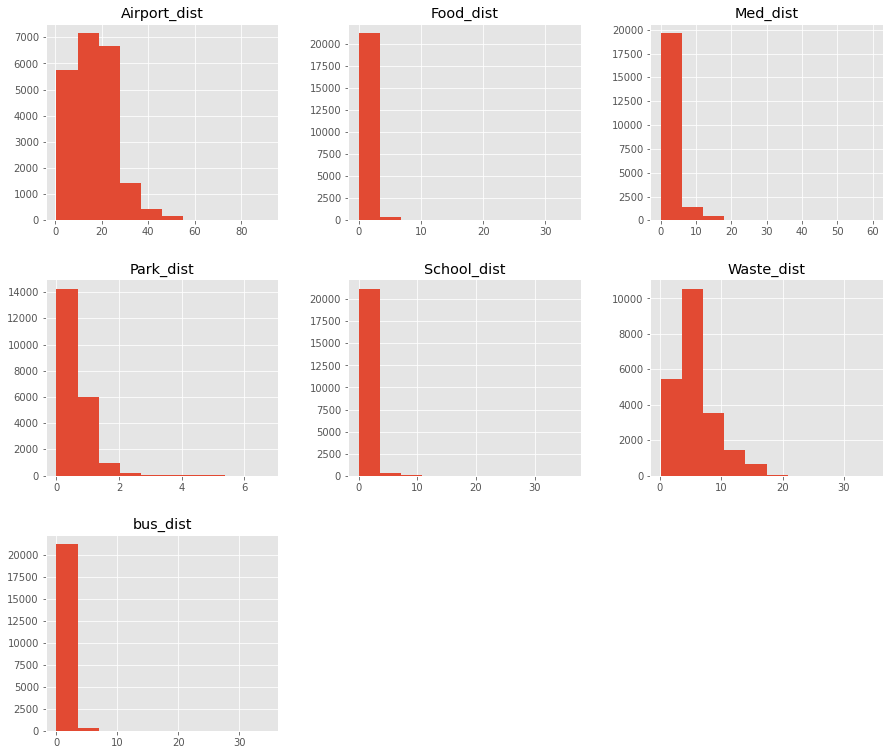

In [81]:
# Let's look at the distribution
df_price_clean.hist(column=["Park_dist", "Food_dist", 
                            'Med_dist', 'Airport_dist', 
                           'Waste_dist', 'School_dist',
                           'bus_dist'], figsize=(15,13))

## Interpretation:
Most of the distances are not normally distributed which seems to be affected by outliers

Text(0.5, 1.0, 'Distance to Food vs Price')

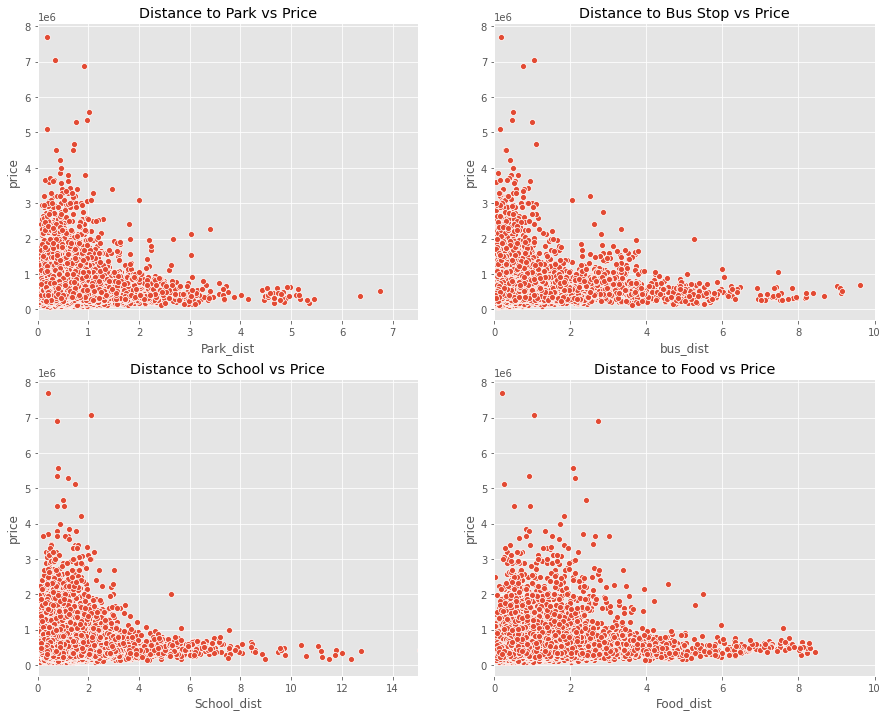

In [82]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

ax1 = sns.scatterplot(x='Park_dist', y = 'price', data=df_price_clean, ax=ax1)
ax1.set_xlim(0,7.5)
ax1.set_title('Distance to Park vs Price')

ax2 = sns.scatterplot(x='bus_dist', y = 'price', data=df_price_clean, ax=ax2)
ax2.set_xlim(0,10)
ax2.set_title('Distance to Bus Stop vs Price')
      
ax3 = sns.scatterplot(x='School_dist', y = 'price', data=df_price_clean, ax=ax3)
ax3.set_xlim(0,15)
ax3.set_title('Distance to School vs Price')

ax4 = sns.scatterplot(x='Food_dist', y = 'price', data=df_price_clean, ax=ax4)
ax4.set_xlim(0,10)
ax4.set_title('Distance to Food vs Price')



### Interpretation: 
The smaller the distance is, the bigger range the price would be. 

Text(0.5, 1.0, 'Distance to Food vs Price')

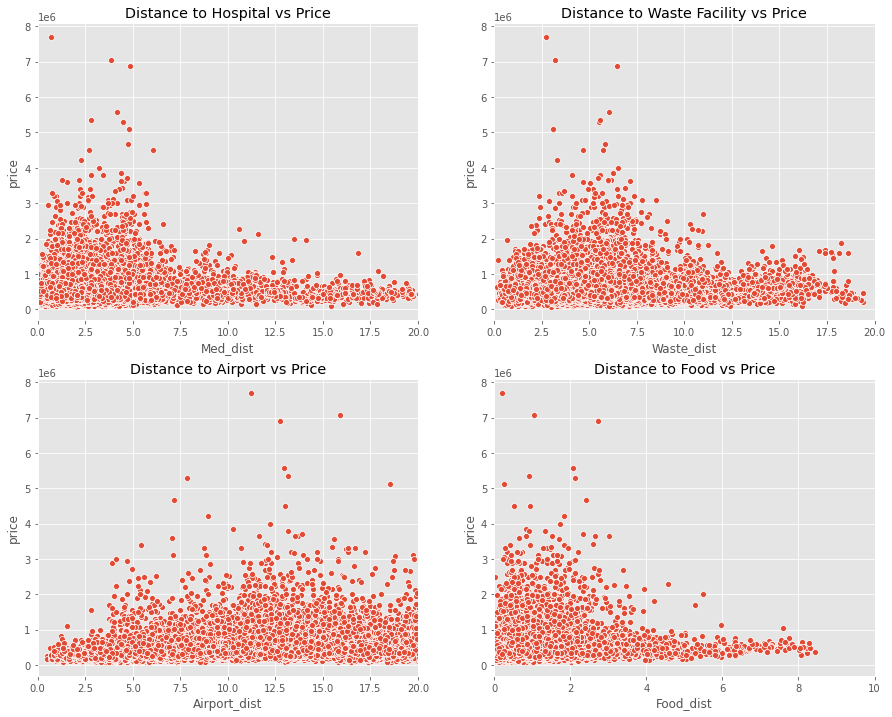

In [85]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

ax1 = sns.scatterplot(x='Med_dist', y = 'price', data=df_price_clean, ax=ax1)
ax1.set_xlim(0,20)
ax1.set_title('Distance to Hospital vs Price')

ax2 = sns.scatterplot(x='Waste_dist', y = 'price', data=df_price_clean, ax=ax2)
ax2.set_xlim(0,20)
ax2.set_title('Distance to Waste Facility vs Price')
      
ax3 = sns.scatterplot(x='Airport_dist', y = 'price', data=df_price_clean, ax=ax3)
ax3.set_xlim(0,20)
ax3.set_title('Distance to Airport vs Price')

ax4 = sns.scatterplot(x='Food_dist', y = 'price', data=df_price_clean, ax=ax4)
ax4.set_xlim(0,10)
ax4.set_title('Distance to Food vs Price')

### Interpretations:
**Hospital** seems to be a preferred feature here.
<br/>
**Airport** is not a preferred feature.
<br/>
**Solid Waste Facility** shows within a moderate distance is acceptable

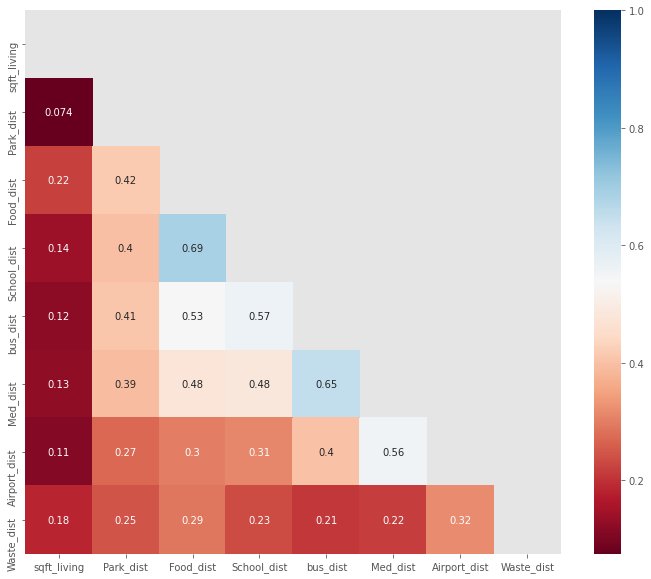

In [86]:
# Let's look at if there are colinearity`
plt.figure(figsize=(12,10))
df_clean_corr = df_price_clean[['sqft_living', 'Park_dist', 'Food_dist', 'School_dist',
                                'bus_dist', 'Med_dist', 
        'Airport_dist', 'Waste_dist']]
corrs = df_clean_corr.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool))
sns.heatmap(corrs, mask=mask,
        xticklabels=corrs.columns,
        yticklabels=corrs.columns, cmap='RdBu', annot=True)

## Interpretations: 
Overall, the colinearity not very concerning. However, school and food have the strongest correlation and very close of the threshold, 0.7

In [87]:
df_price_clean.columns

Index(['id', 'price', 'sqft_living', 'zipcode', 'lat', 'long', 'geometry',
       'Nearest_Park', 'Nearest_food', 'Nearest_airport', 'Nearest_waste',
       'Nearest_school', 'Nearest_bus', 'Nearest_med', 'Park_dist',
       'Food_dist', 'Med_dist', 'Airport_dist', 'Waste_dist', 'School_dist',
       'bus_dist'],
      dtype='object')

In [88]:
# Stats Model looking for correlation
model1 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + bus_dist + Med_dist + Airport_dist + Waste_dist + sqft_living', 
                 data=df_price_clean).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2876.
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:17:46   Log-Likelihood:            -2.9956e+05
No. Observations:               21597   AIC:                         5.991e+05
Df Residuals:                   21588   BIC:                         5.992e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.425e+04   5646.649      6.065      0.000    2.32e+04    4.53e+04
Park_dist    -7.094e+04   4405.612    -16.102      0.000   -7.96e+04   -6.23e+04
School_dist   8930.3458   2822.646      3.164      0.002    3397.750    1.45e+04
Food_dist    -2.403e+04   2897.005     -8.294      0.000   -2.97e+04   -1.84e+04
bus_dist     -3681.3579   2249.403     -1.637      0.102   -8090.355     727.639
Med_dist     -1629.7042    800.010     -2.037      0.042   -3197.783     -61.625
Airport_dist   297.2225    228.990      1.298      0.194    -151.615     746.060
Waste_dist   -7348.9168    586.604    -12.528      0.000   -8498.703   -6199.131
sqft_living    293.1444      1.963    149.369      0.000     289.298     296.991
==============================================================================
Omnibus:                    14717.849   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           550867.176
Skew:                           2.788   Prob(JB):                         0.00
Kurtosis:                      27.105   Cond. No.                     7.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation: 
1. Distance to bus stops and airports seem to be not very signicant. It can be possible that many people do drive in Kings County.
2. From previous graph, we noticed that price tend to be similar (smaller range) after certain distnace. The next step would be excluding some outliers and see if the model can have better predictability power

## 4.3 Model testing
### 4.3.1 Multi-variate linear regression
Baseline Model testing

In [89]:

X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist', 
                    'bus_dist', 'Waste_dist', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5126986281022073

In [90]:
# Cross-validation
kfold = model_selection.KFold(n_splits=10, random_state=123)
model_kfold = LinearRegression()
results_kfold = model_selection.cross_val_score(model_kfold, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 51.24%


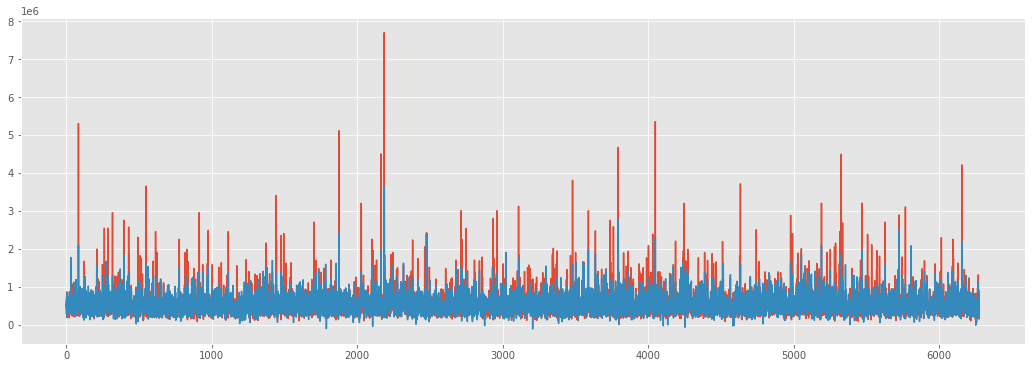

In [127]:
y_test_arr = np.array(y_test)
plt.figure(figsize=(18,6))
plt.plot(y_test_array)
plt.plot(y_pred)

### Polynomial

In [91]:
X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'bus_dist', 'Waste_dist', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)

In [92]:
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)


degree 2 0.5814458495375316
degree 3 0.6044289405826635
degree 4 -1.4239759967214485
degree 5 -2.69321699112152


### 4.3.2 Next Step & Model Improvement: 
The predicting power is the highest for 3rd degree polynomial. As we noticed before from distances, let's try to exclude the outliers and see if that would improve the model

In [93]:
# Eliminate outliers
# Using 5km as a threshold for food, bus stop, and schools
# 15 km for hospitals
# 4km for parks
# Further from the airport (at least 2km)
# Further from the waste facility (at least 2km)
df_price_clean_small = df_price_clean[(df_price_clean.Food_dist<5)&(df_price_clean.School_dist<5)&(df_price_clean.bus_dist<5)&(df_price_clean.Park_dist<5)&(df_price_clean.Airport_dist>2)&(df_price_clean.Waste_dist>2)&(df_price_clean.Med_dist<15)]
len(df_price_clean_small)

19020

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b108710>,
      dtype=object)

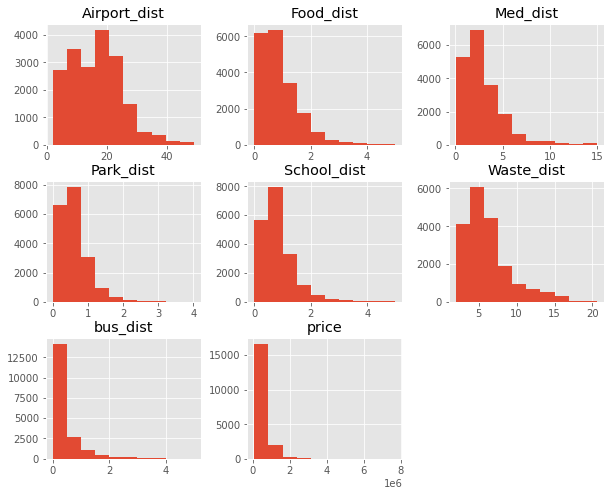

In [94]:
# Check the distribution
df_price_clean_small.hist(column=["price", "Park_dist", "Food_dist", 
                            'Med_dist', 'Airport_dist', 
                           'Waste_dist', 'School_dist',
                           'bus_dist'], figsize=(10,8))

In [95]:
# Check OLS model
model2 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + bus_dist + Med_dist + Waste_dist + sqft_living', 
                 data=df_price_clean_small).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     3086.
Date:                Wed, 09 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:18:18   Log-Likelihood:            -2.6414e+05
No. Observations:               19020   AIC:                         5.283e+05
Df Residuals:                   19012   BIC:                         5.284e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.357e+04   6284.692      6.933      0.000    3.13e+04    5.59e+04
Park_dist   -8.214e+04   5213.377    -15.755      0.000   -9.24e+04   -7.19e+04
School_dist  1.024e+04   4021.489      2.547      0.011    2359.826    1.81e+04
Food_dist   -2.362e+04   3701.159     -6.380      0.000   -3.09e+04   -1.64e+04
bus_dist    -3.127e+04   4201.082     -7.444      0.000   -3.95e+04    -2.3e+04
Med_dist    -1893.5415   1015.866     -1.864      0.062   -3884.728      97.645
Waste_dist  -8979.9249    688.916    -13.035      0.000   -1.03e+04   -7629.588
sqft_living   307.4341      2.145    143.344      0.000     303.230     311.638
==============================================================================
Omnibus:                    12564.754   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           428767.923
Skew:                           2.689   Prob(JB):                         0.00
Kurtosis:                      25.630   Cond. No.                     8.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation: 
The R score increased a little bit. P value for all feasures are demonstrating: they are significant features. 

In [123]:
# Model testing
X = df_price_clean_small[['Park_dist', 'School_dist', 'Food_dist', 'bus_dist', 
                    'Waste_dist', 'sqft_living']]
y = df_price_clean_small['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5431542160345271

In [120]:
y_test_array = np.array(y_test)

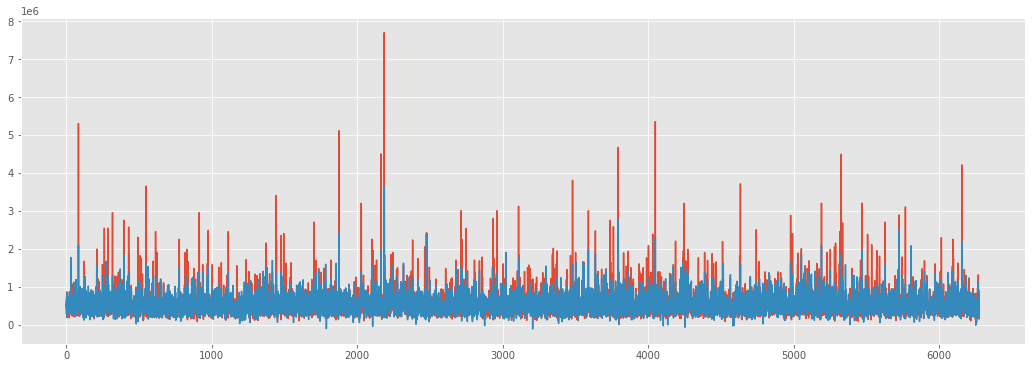

In [126]:
plt.figure(figsize=(18,6))
plt.plot(y_test_array)
plt.plot(y_pred)

## Interpretation:
The model seems not able to capture very high prices

In [131]:
# Cross-validation
kfold = model_selection.KFold(n_splits=10, random_state=52)
model_kfold = LinearRegression()
results_kfold = model_selection.cross_val_score(model_kfold, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 52.71%


In [132]:
X = df_price_clean_small[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 
                    'Waste_dist', 'sqft_living']]
y = df_price_clean_small['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)

for index, degree in enumerate([2, 3, 4, 5]):
    
    poly = PolynomialFeatures(degree)
    
    X_poly_train = poly.fit_transform(X_train)
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    X_poly_test = poly.transform(X_test)
    
    y_pred = reg_poly.predict(X_poly_test)
    
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    X_poly = poly.transform(X)
    y_poly = reg_poly.predict(X_poly)


degree 2 0.6204573154706585
degree 3 0.6305127812355349
degree 4 0.6339198134509114
degree 5 0.1811150587356014


### Interpretation: 
Polynomial increase around 3 to 6 percent. However, degree 3 and 4 might have the problem with overfitting. Also the variables are not normally distributed

### 4.3.3 Scaling and distribution

In [133]:
# Applying log to each feature
# As price, sqft, and distance are at different dimensional level and digit level
df_price_clean['price_log'] = np.log(df_price_clean.price)
df_price_clean['sqft_log'] = np.log(df_price_clean.sqft_living)
df_price_clean['park_log'] = np.log(df_price_clean.Park_dist)
df_price_clean['school_log'] = np.log(df_price_clean.School_dist)
df_price_clean['food_log'] = np.log(df_price_clean.Food_dist)
df_price_clean['med_log'] = np.log(df_price_clean.Med_dist)
df_price_clean['air_log'] = np.log(df_price_clean.Airport_dist)
df_price_clean['waste_log'] = np.log(df_price_clean.Waste_dist)
df_price_clean['bus_log'] = np.log(df_price_clean.bus_dist)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1503b4358>,
      dtype=object)

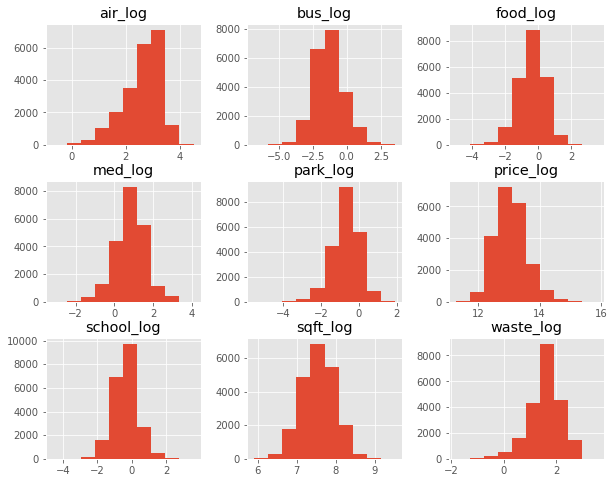

In [134]:
df_price_clean.hist(column=["price_log", "park_log", "food_log", 
                            'med_log', 'air_log', 
                           'waste_log', 'school_log',
                           'bus_log', 'sqft_log'], figsize=(10,8))

## Interpretation:
Normality is a lot better

In [137]:
# Model testing
X = df_price_clean[['park_log', 'school_log', 'food_log', 'med_log', 'air_log', 
                          'bus_log','waste_log', 'sqft_log']]
y = df_price_clean['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5114225525831555

In [138]:
# Applying max-min scale to each feature
# As price, sqft, and distance are at different dimensional level and digit level
data = np.array(df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                   'bus_dist', 'Waste_dist', 'sqft_living', 'price']])
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled[1]

array([0.04948623, 0.01310265, 0.02135827, 0.02632211, 0.22811617,
       0.00284683, 0.09385607, 0.16704632, 0.06035161])

In [139]:
# Putting into the model
X = np.delete(scaled, np.s_[-1], 1)
y = np.delete(scaled, np.s_[0:8], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5126986281022075

### Summary: 
Scaling did not really improve the model

## 4.4 Spatial regions correction and model improvement
For a neighbourhood (by Zipcode) that is bigger, price statistics can be biased. The size of a certain neighbourhood can affect the house density, distance to important features and furthermore, the price. 
Based on the size of the neighbourhood, let's do a spatial lag correction on the price and see if that would help with improving the model. 

In [114]:
# Zipcode boundary
zip_link = 'https://opendata.arcgis.com/datasets/e6c555c6ae7542b2bdec92485892b6e6_113.zip'
urllib.request.urlretrieve(zip_link, 'zip_file.gz')
!mkdir zipcode
!unzip -d zipcode zip_file.gz
zip_poly = gpd.GeoDataFrame.from_file(glob.glob("zipcode/*.shp")[0])

mkdir: zipcode: File exists
Archive:  zip_file.gz
replace zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [115]:
df_price_clean.zipcode = df_price_clean.zipcode.astype(int)
zip_poly.ZIPCODE = zip_poly.ZIPCODE.astype(int)
df_zip_join = pd.merge(df_price_clean, zip_poly, left_on = 'zipcode', 
                       right_on = 'ZIPCODE', how='left' )
df_join_sl = df_zip_join
zip_list = [i for i in df_zip_join.ZIPCODE.unique()]
zip_houses = zip_poly[zip_poly.ZIPCODE.isin(zip_list)]

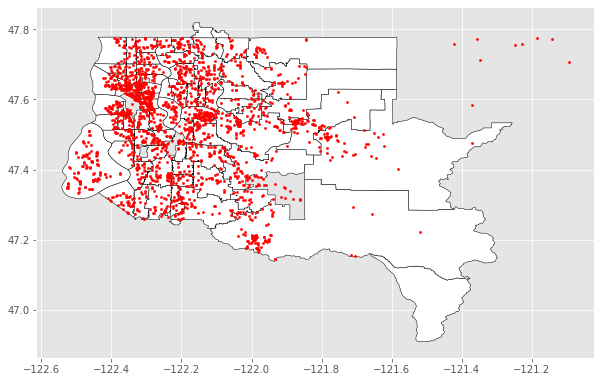

In [116]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
set1 = zip_houses.plot(edgecolor='Black', color = 'white', ax=ax, legend=True)
set2 = parks.plot(color='Red', ax=ax, markersize=5)

### Interpretation:
A few houses in the further east area did not show a proper zipcode base. Those houses will be excluded. 

## Spatial Lag for Price normalization

In [117]:
df_spatial = df[['id', 'price', 'sqft_living', 'lat', 'long', 'zipcode']]
df_spatial['price_per_sqft'] = df_spatial.price/df_spatial.sqft_living
df_spatial_geo = gpd.GeoDataFrame(df_spatial, 
                              geometry=gpd.points_from_xy(df_spatial.long, df_spatial.lat))
df_spatial.zipcode = df_spatial.zipcode.astype(int)
zip_poly.ZIPCODE = zip_poly.ZIPCODE.astype(int)

In [118]:
group_price_med = df_price_clean_small.groupby(['zipcode'])['price'].agg('median')
group_med = pd.DataFrame(group_price_med)

In [119]:
group_new_med = pd.merge(group_med, zip_poly, left_on = 'zipcode', 
                         right_on='ZIPCODE', how='left')
group_geo_med = gpd.GeoDataFrame(group_new_med, geometry = 'geometry')

In [120]:
# Autocorrection median
# Price correction 
df_sl_med = group_geo_med
wq = lps.weights.Kernel.from_dataframe(df_sl_med, k = 20)
y = df_sl_med['price']
ylag = lps.weights.lag_spatial(wq, y)
ylagq5 = mc.Quantiles(ylag, k=10)
df_sl_med['lag_median_pri'] = ylag

Text(0.5, 1.0, 'Spatial Lag Price')

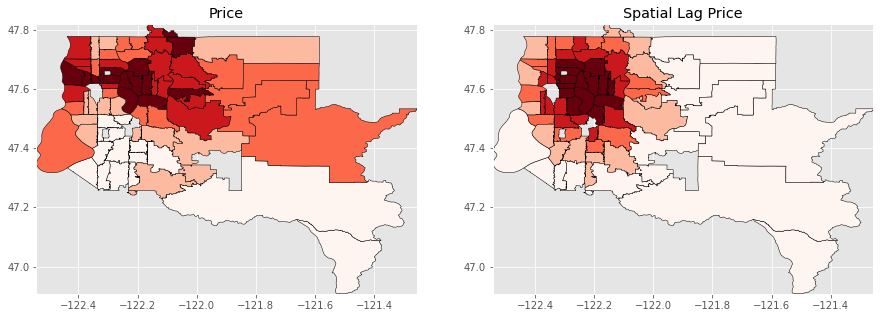

In [121]:
df_sl_med['lag_median_pri'] = ylag
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#price vs lag corrected price
df_sl_med.plot(column='price', ax=ax1, edgecolor='k',
        scheme="quantiles",  k=5, cmap='Reds')
ax1.axis(df_sl_med.total_bounds[np.asarray([0,2,1,3])])
ax1.set_title("Price")
df_sl_med.plot(column='lag_median_pri', ax=ax2, edgecolor='k',
        scheme='quantiles', cmap='Reds', k=5)
ax2.axis(df_sl_med.total_bounds[np.asarray([0,2,1,3])])
ax2.set_title("Spatial Lag Price")

### Transforming the price data based on the new Zipcode median
Local transformation for each houses price

In [122]:
df_sl_med['factor'] = df_sl_med['lag_median_pri']/df_sl_med['price']

In [123]:
df_factors_med = df_sl_med[['ZIPCODE', 'factor']]

df_price_clean_small.zipcode = df_price_clean_small.zipcode.astype(int)
df_med = pd.merge(df_price_clean_small, df_factors_med, 
                   left_on='zipcode', right_on='ZIPCODE', how='left')
df_med['price_adj'] = df_med.price * df_med.factor

In [124]:
# Run model again
X = df_med[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_med['price_adj']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.48890029087205716

In [125]:
X = df_med[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_med['price_adj']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train)
    
    
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    X_poly_test = poly.transform(X_test)
    
    y_pred = reg_poly.predict(X_poly_test)
    
    print("degree %d" % degree, r2_score(y_test, y_pred))
    X_poly = poly.transform(X)
    y_poly = reg_poly.predict(X_poly)


degree 2 0.5391027167625417
degree 3 0.5645379391727752
degree 4 0.4745097999746539
degree 5 -0.22451901690534148
